In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import cv2
import time

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [2]:
# Prepare data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = Dataset(dataset_root, download=True, train=True, transform=transform)
testset = Dataset(dataset_root, download=True, train=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

In [3]:
# Create data loaders

batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Class: Ankle boot
Shape: (1, 28, 28)


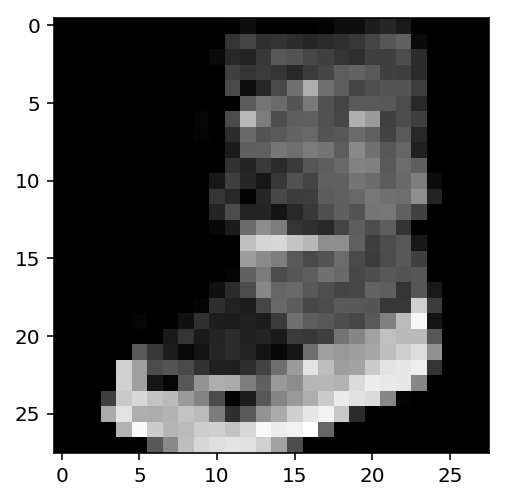

In [4]:
# Show random image shape using iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
plt.imshow(np.squeeze(images[idx]), cmap='gray')
print('Class: ' + str(classes[labels[idx]]))
print('Shape: ' + str(images[idx].shape))

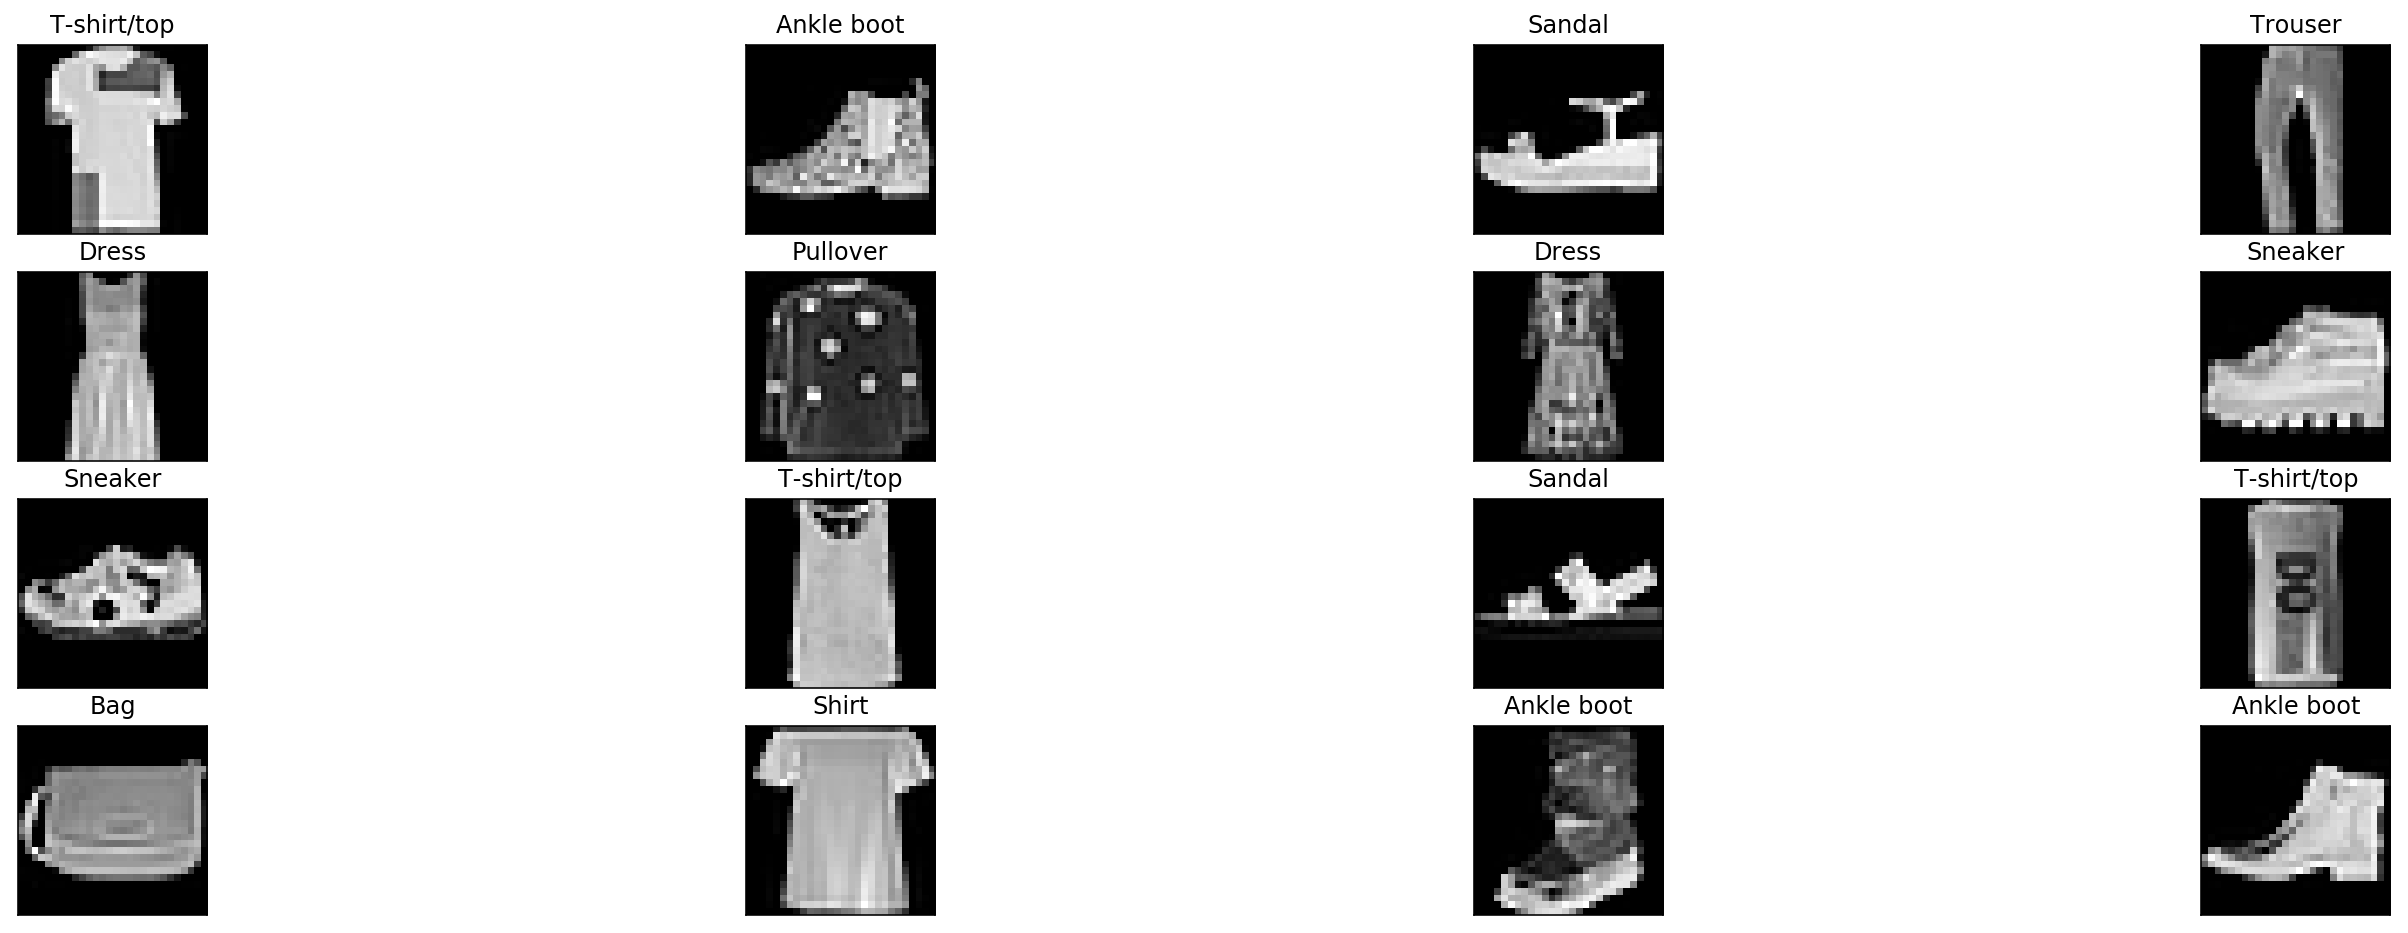

In [5]:
# Show full batch size

fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

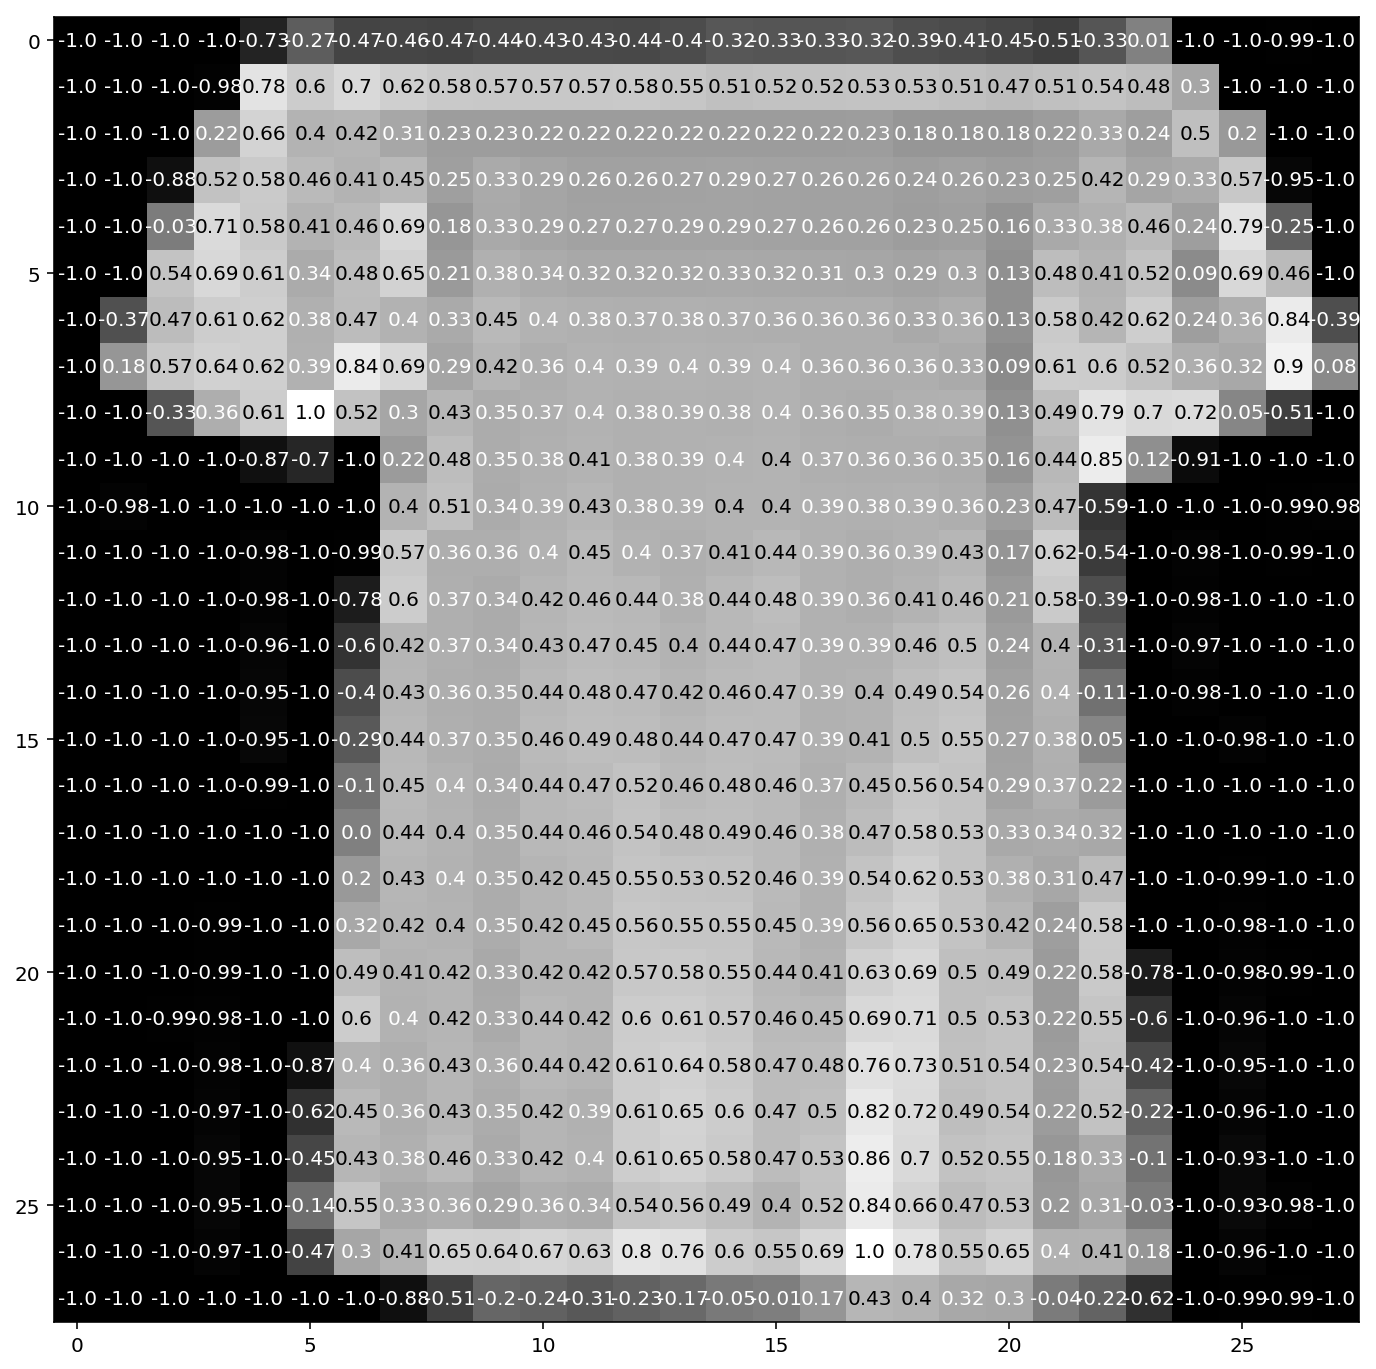

In [6]:
# Show image displaying the value of each pixel

idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])

# Show image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')


# Add pixel value
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0 # round to 2 decimals
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black') # Just to be able to see the number

<https://pytorch.org/docs/stable/nn.html#conv2d>

In [21]:
# Define our convolutional neural network

import torch.nn as nn
import torch.nn.functional as F

class CNNet(nn.Module):

    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, 4), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.linear1 = nn.Linear(32*7*7, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1) #flatten the image 
        x = self.linear1(x)
        return x

# instantiate and print your Net
model = CNNet()
print(model)

CNNet(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1568, out_features=10, bias=True)
)


In [22]:
# Add batch size using unsqueeze

print(str(images[idx].shape))
img_pt = torch.from_numpy(images[idx]).unsqueeze(0)
print(str(img_pt.shape))

(1, 28, 28)
torch.Size([1, 1, 28, 28])


In [23]:
# Calculate predictions for one sample image
model(img_pt)

tensor([[-0.1994,  0.0590,  0.2861, -0.1347, -0.2365, -0.0277,  0.1358, -0.0855,
          0.2004,  0.1030]], grad_fn=<AddmmBackward>)

In [24]:
# Define loss function 

criterion = nn.CrossEntropyLoss()

In [25]:
# Calculate accuracy before training

def eval_model_on_test_set():
    model.eval()
    correct = 0
    total = 0
    total_loss = torch.zeros(1)

    for images, labels in test_loader:

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1) # outputs -> value, index

        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100.0 * correct.item() / total
    print('Accuracy: {}, Test Loss: {}'.format(accuracy, (total_loss * batch_size / total).item()))

eval_model_on_test_set()    

Accuracy: 12.06, Test Loss: 2.328772783279419


In [26]:
# Train loop

print_every = 100

def train(n_epochs):
    model.train()
    loss_over_time = [] # to track the loss as the network trains
    start_time = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % print_every == print_every//2:    # print every 100 batches (staring from 50)
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, Time: {}'.format(epoch + 1, batch_i+1, avg_loss, str(time.time() - start_time)))
                running_loss = 0.0
                start_time = time.time()
                eval_model_on_test_set()
                model.train()

    print('Finished Training')
    return loss_over_time


In [27]:
# Train the model
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 2 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 51, Avg. Loss: 0.7651997536420823, Time: 0.4807589054107666
Accuracy: 66.55, Test Loss: 0.9933332204818726
Epoch: 1, Batch: 151, Avg. Loss: 0.7292807403206826, Time: 3.8217477798461914
Accuracy: 71.44, Test Loss: 0.7624770402908325
Epoch: 1, Batch: 251, Avg. Loss: 0.6257014934718609, Time: 3.842397928237915
Accuracy: 79.87, Test Loss: 0.5813379287719727
Epoch: 1, Batch: 351, Avg. Loss: 0.5343910166621209, Time: 3.791764974594116
Accuracy: 80.91, Test Loss: 0.5371736884117126
Epoch: 1, Batch: 451, Avg. Loss: 0.5304829518496991, Time: 3.84394907951355
Accuracy: 81.18, Test Loss: 0.5269327759742737
Epoch: 1, Batch: 551, Avg. Loss: 0.529811535179615, Time: 3.8068318367004395
Accuracy: 80.29, Test Loss: 0.5292155146598816
Epoch: 1, Batch: 651, Avg. Loss: 0.503846597224474, Time: 3.8088741302490234
Accuracy: 81.14, Test Loss: 0.5215527415275574
Epoch: 1, Batch: 751, Avg. Loss: 0.4870325345546007, Time: 3.794304132461548
Accuracy: 83.99, Test Loss: 0.457718163728714
Epoch: 1,

Accuracy: 89.32, Test Loss: 0.29815784096717834
Epoch: 2, Batch: 2951, Avg. Loss: 0.3022276208922267, Time: 3.7352139949798584
Accuracy: 89.3, Test Loss: 0.30173730850219727
Epoch: 2, Batch: 3051, Avg. Loss: 0.26794662661850455, Time: 3.755418062210083
Accuracy: 88.47, Test Loss: 0.3155082166194916
Epoch: 2, Batch: 3151, Avg. Loss: 0.2729522205144167, Time: 3.7226197719573975
Accuracy: 89.29, Test Loss: 0.2956680655479431
Epoch: 2, Batch: 3251, Avg. Loss: 0.2687354610860348, Time: 3.7516629695892334
Accuracy: 88.87, Test Loss: 0.30614376068115234
Epoch: 2, Batch: 3351, Avg. Loss: 0.29045161299407485, Time: 3.7578651905059814
Accuracy: 89.29, Test Loss: 0.2963753640651703
Epoch: 2, Batch: 3451, Avg. Loss: 0.27651872269809247, Time: 3.727447986602783
Accuracy: 88.37, Test Loss: 0.3162137567996979
Epoch: 2, Batch: 3551, Avg. Loss: 0.2714180931448936, Time: 3.736562967300415
Accuracy: 89.52, Test Loss: 0.297342985868454
Epoch: 2, Batch: 3651, Avg. Loss: 0.27609049290418625, Time: 3.7351906

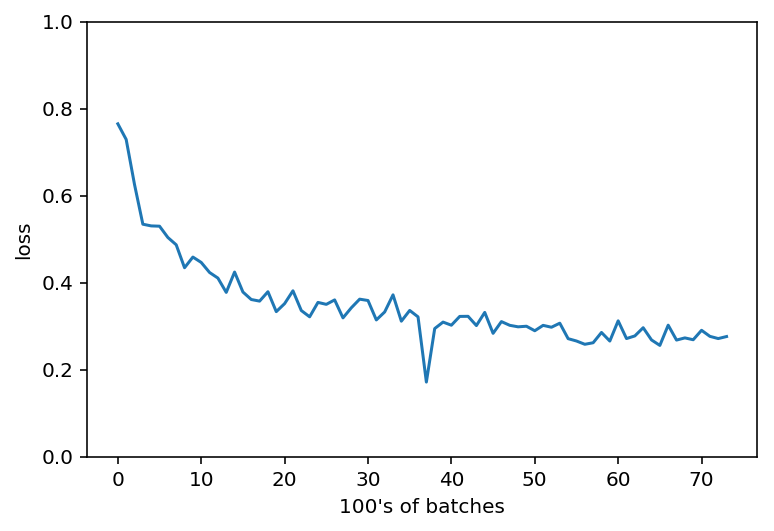

In [28]:
# Show training loss

plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.show()

In [29]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.302435

Test Accuracy of T-shirt/top: 76% (147/193)
Test Accuracy of Trouser: 99% (303/306)
Test Accuracy of Pullover: 83% (234/280)
Test Accuracy of Dress: 87% (259/297)
Test Accuracy of  Coat: 88% (239/270)
Test Accuracy of Sandal: 97% (273/279)
Test Accuracy of Shirt: 79% (228/288)
Test Accuracy of Sneaker: 98% (296/302)
Test Accuracy of   Bag: 96% (265/274)
Test Accuracy of Ankle boot: 95% (266/280)

Test Accuracy (Overall): 90% (2510/2769)


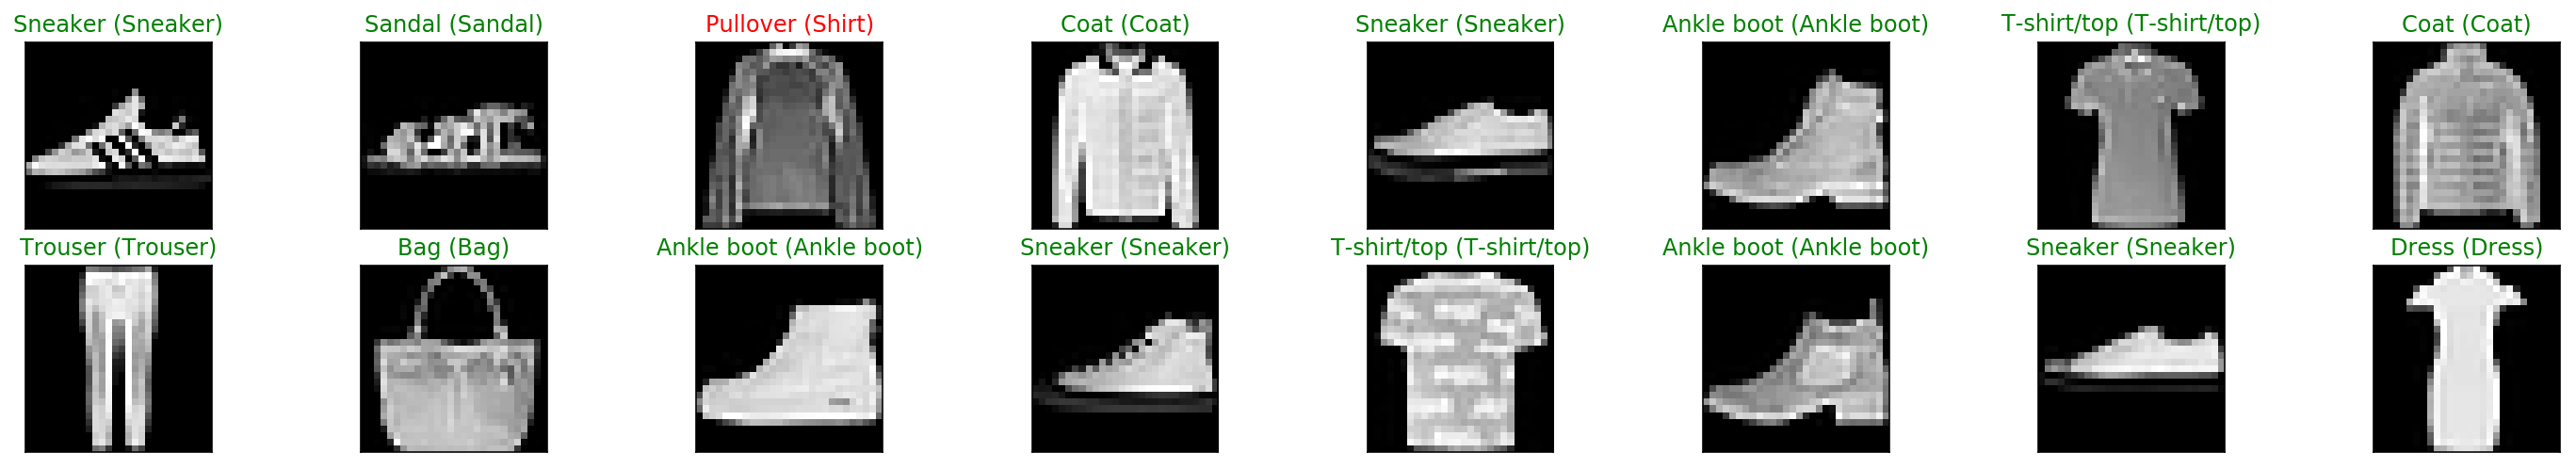

In [30]:
# obtain one batch of test images with its predictions

dataiter = iter(test_loader)
images, labels = dataiter.next()

# get predictions
preds = np.squeeze(model(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Viz

First convolutional layer


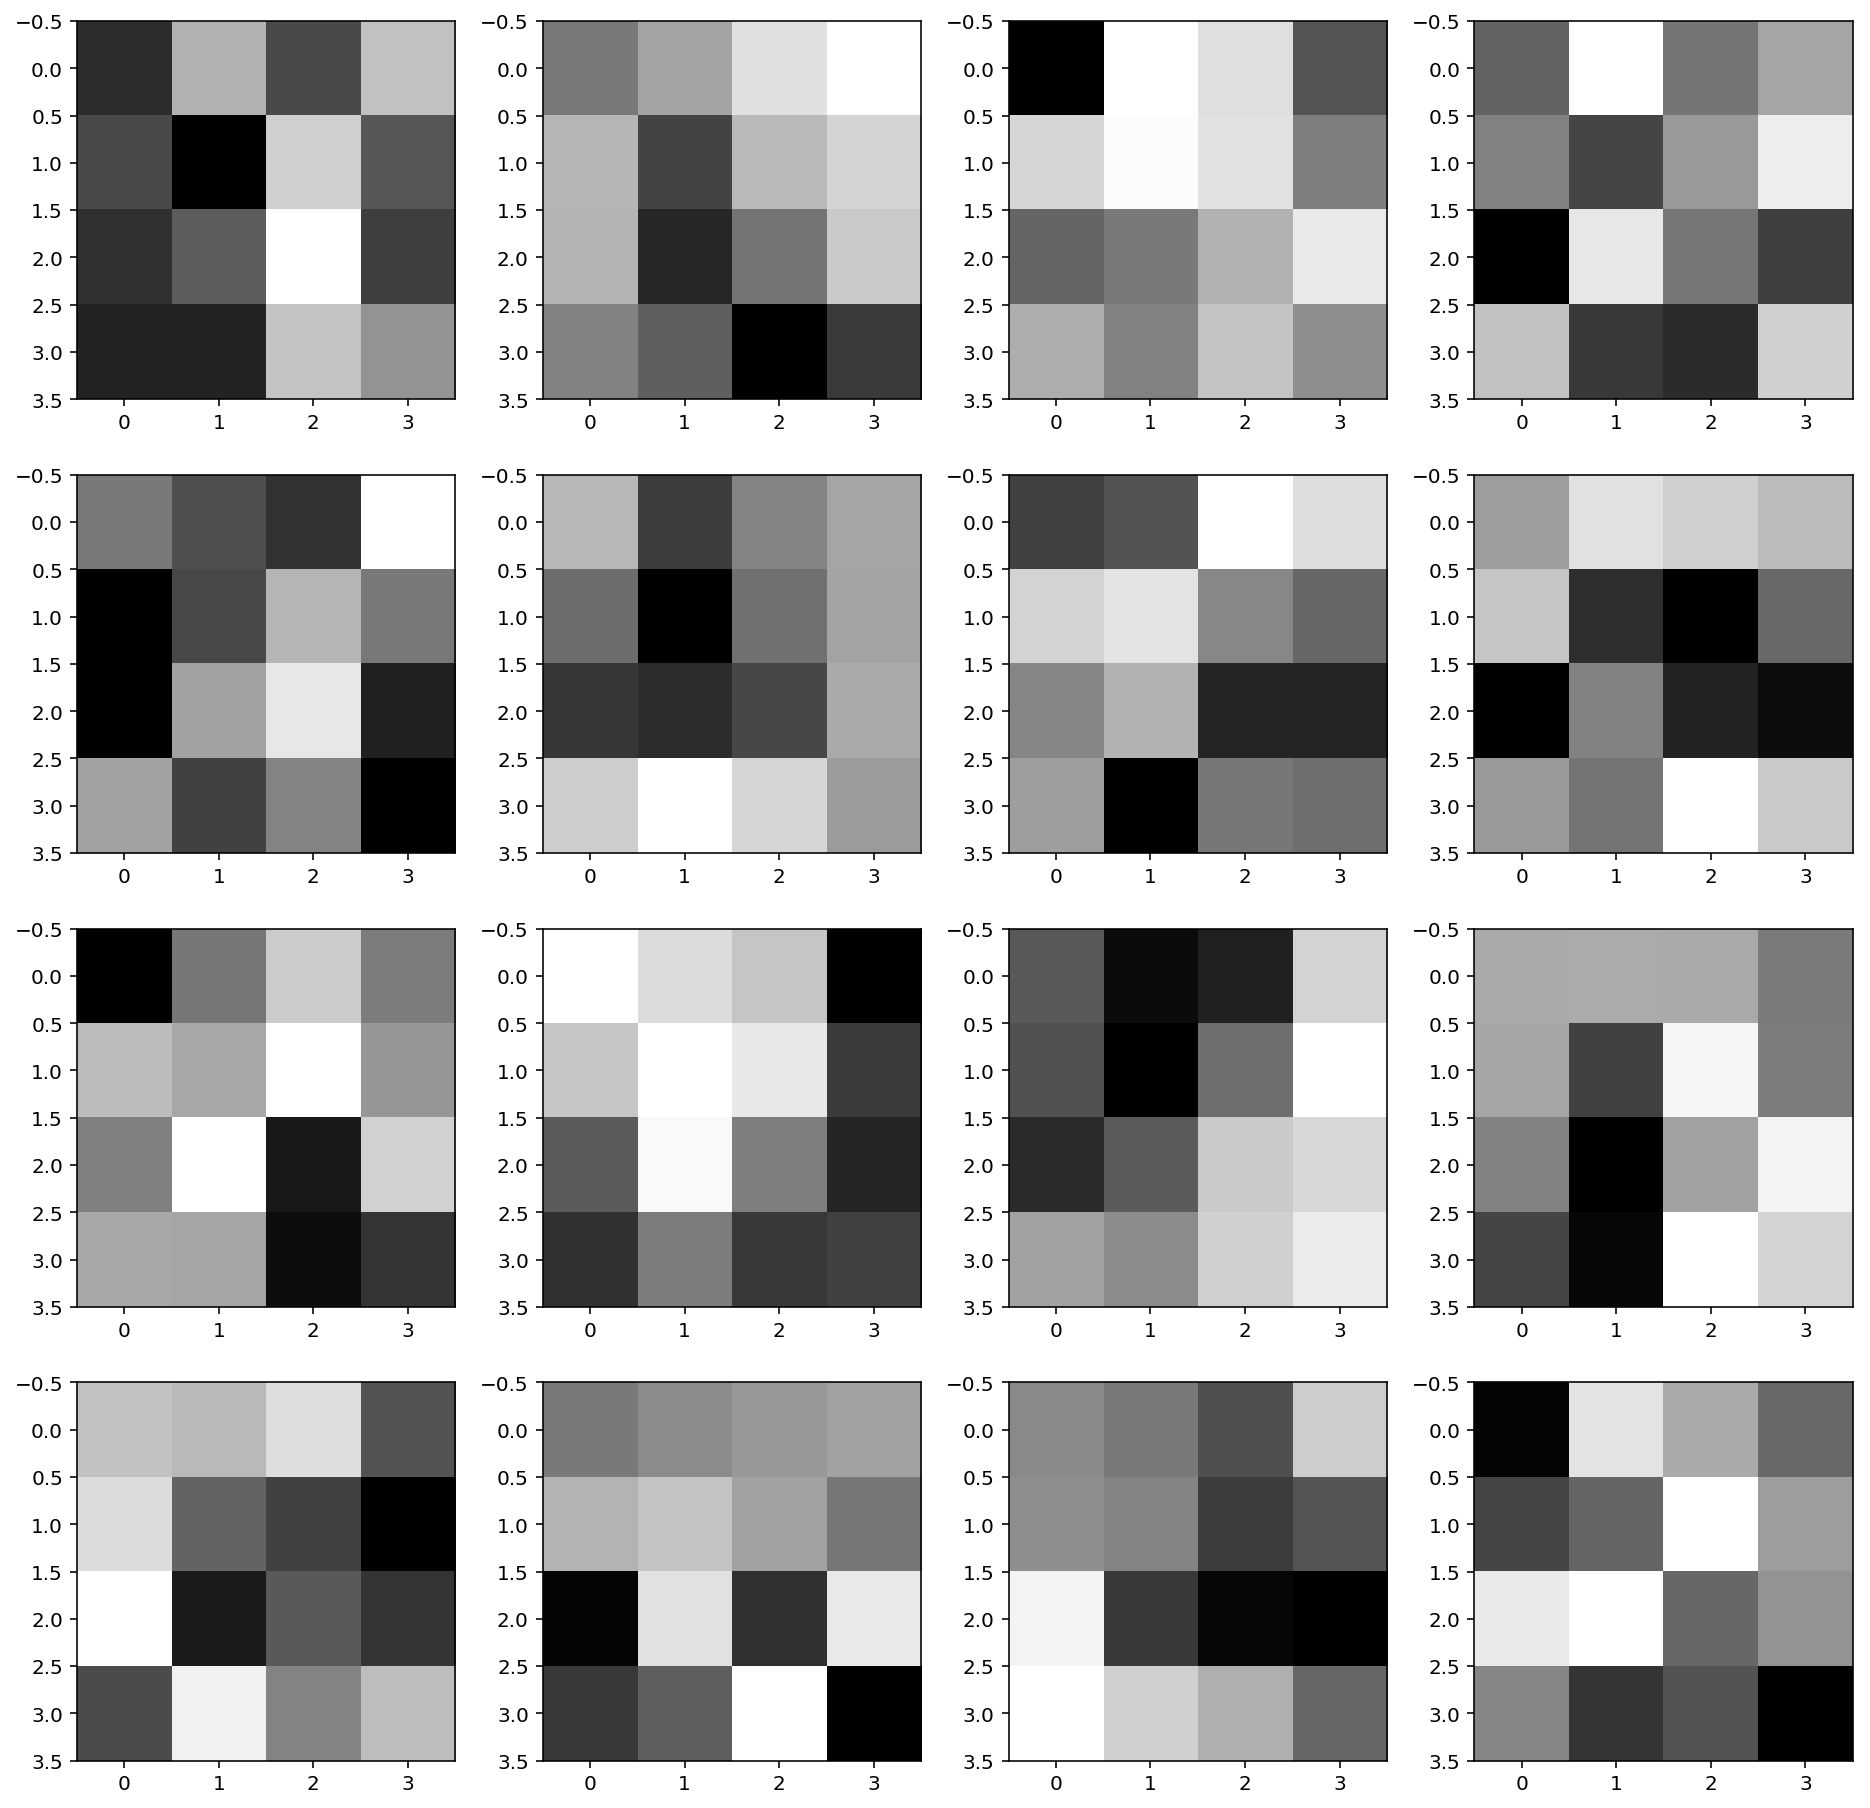

In [31]:
# Get the weights/kernels in the first conv layer
weights = model.conv1.weight.data
w = weights.numpy()

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = model.conv2.weight.data
w = weights.numpy()

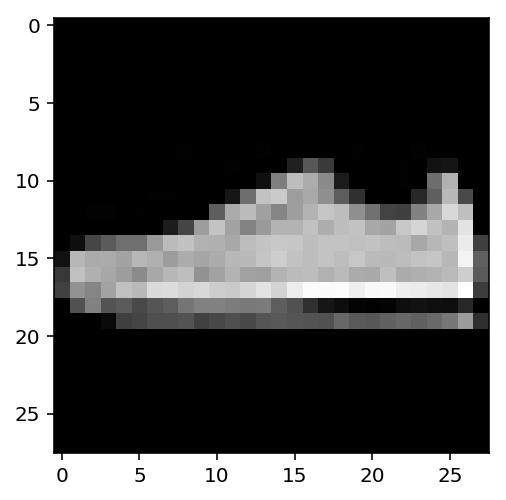

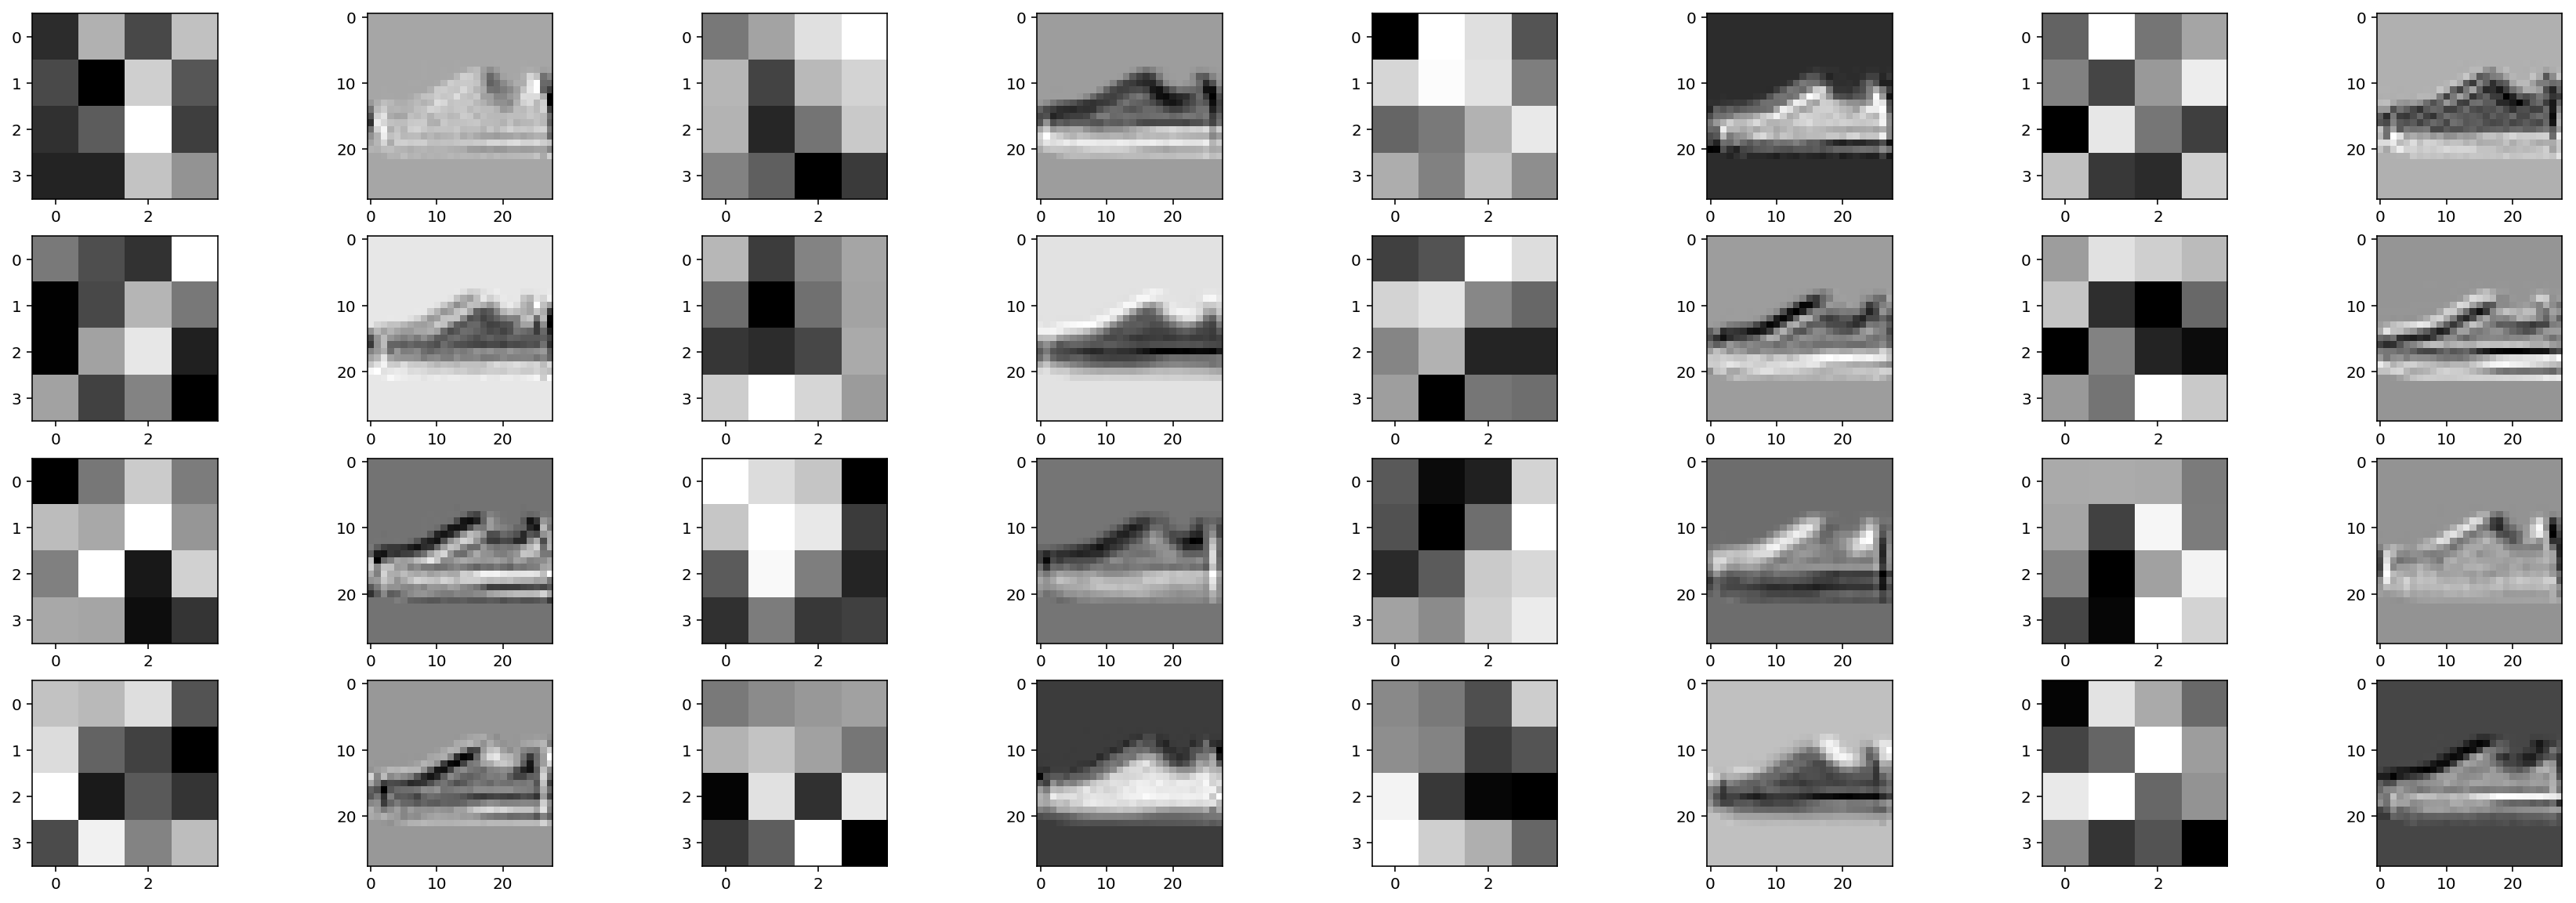

In [32]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])

# show image
plt.imshow(img, cmap='gray')

weights = model.conv1.weight.data
w = weights.numpy()

# First conv layer
fig=plt.figure(figsize=(30, 10))
columns = 4*2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

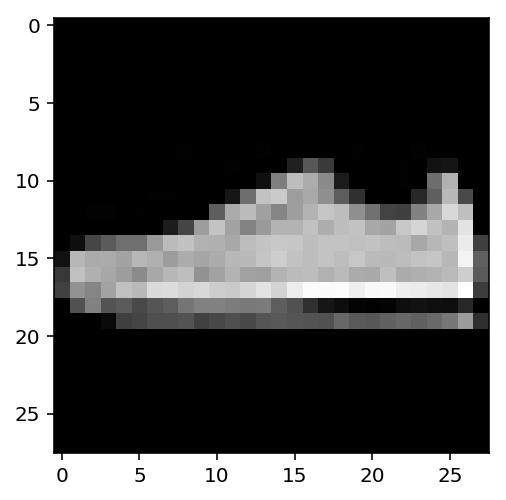

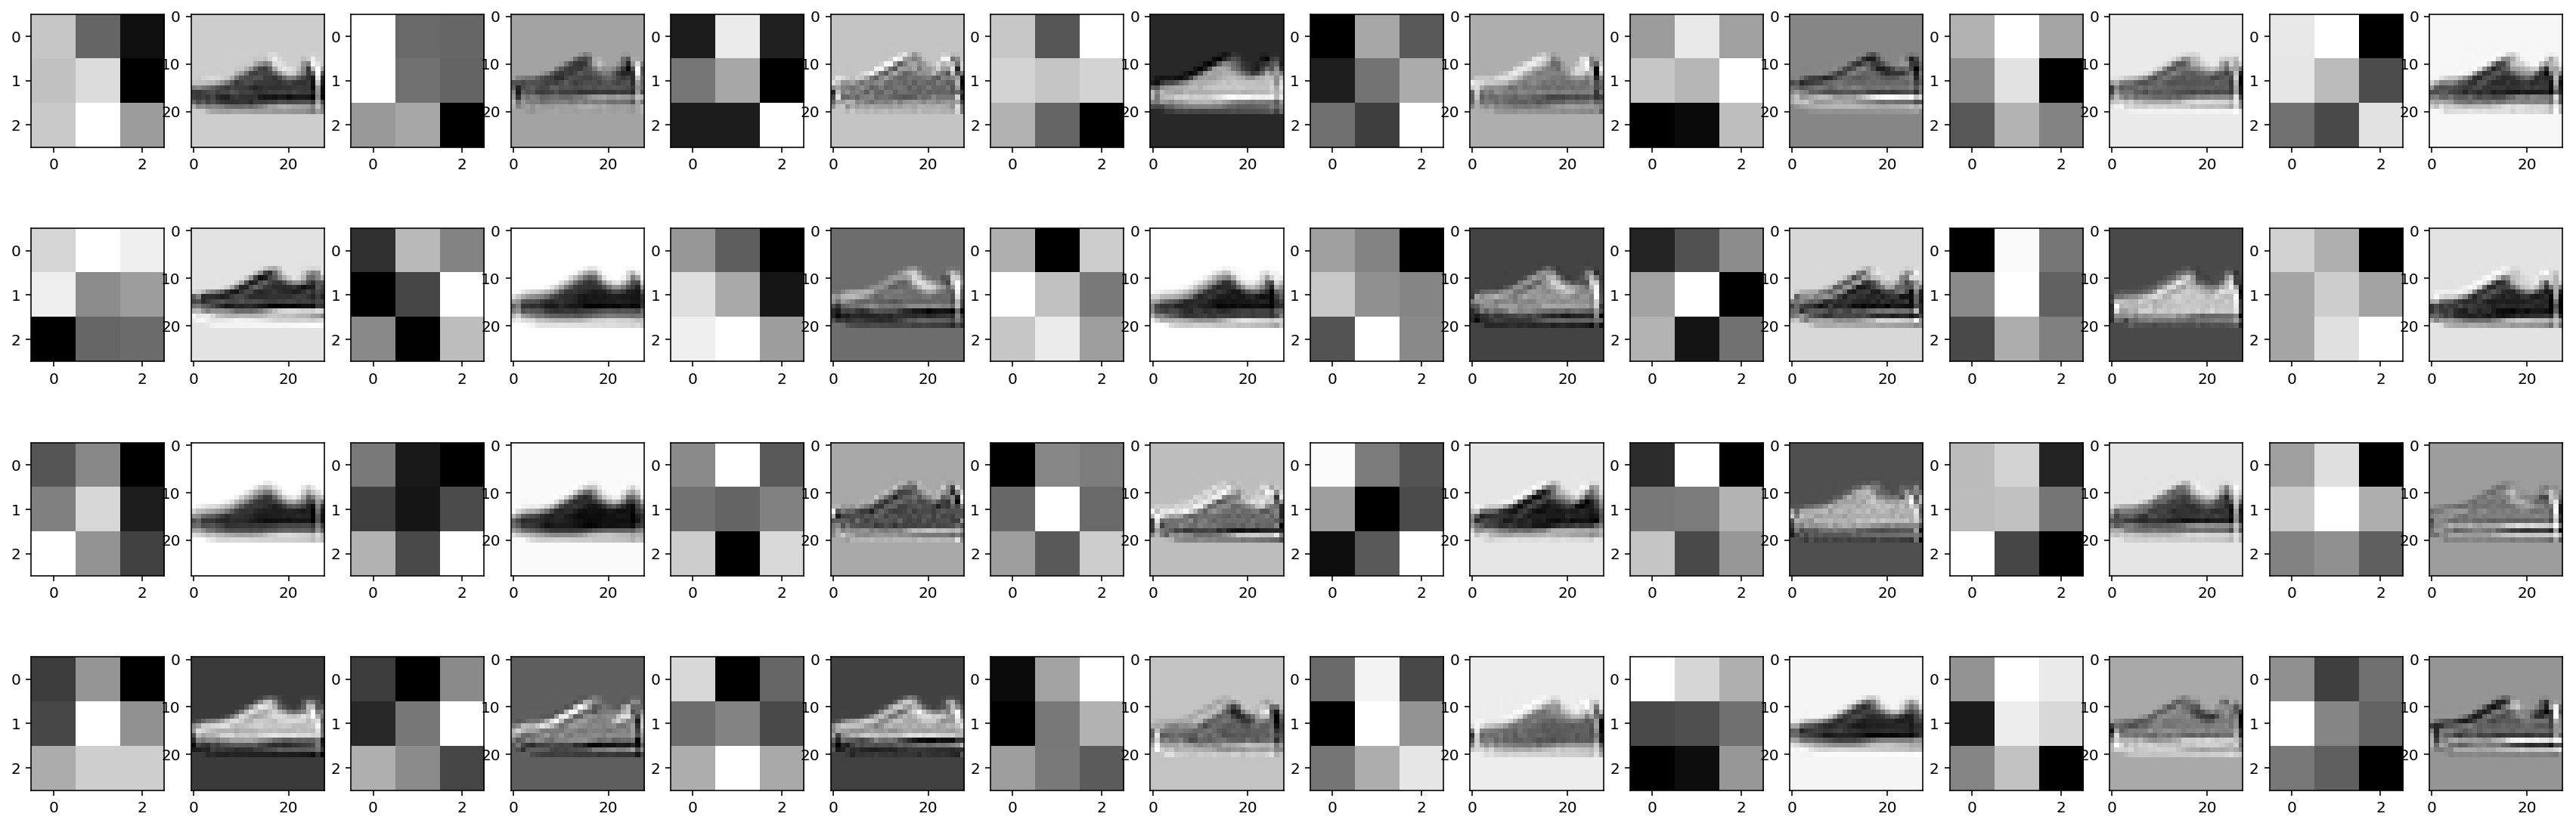

In [33]:
# Same process but for the second conv layer (32, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = model.conv2.weight.data
w = weights.numpy()

# Second conv layer
fig=plt.figure(figsize=(30, 10))
columns = 8*2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

# Exercice: Create your own version of VGG13

VGG has 2 different parts: backbone and classifier

An image of the architecture:
https://i.imgur.com/uLXrKxe.jpg

Some usefull documentation:
* https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
* https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d
* https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU
* https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
  


In [34]:
# VGG13 model from torchvision

import torchvision.models as models
modelToImplement = models.vgg13()
modelToImplement

# input size of the first conv layer should be 1 instead of 3!

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class VGG13(nn.Module):

    def __init__(self, backbone, classifier):
        super().__init__()   
        self.backbone = backbone
        self.adaptativeAveragePool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.classifier = classifier
        
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.adaptativeAveragePool(x)
        x = x.view(x.size(0), -1) #flatten the image 
        x = self.classifier(x)
        return x

In [36]:
def get_conv2d_block(input_size, output_size):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=(3, 3), padding=1),
        nn.ReLU(True)
    )

In [37]:
def get_vgg_block(input_size, output_size):
    return nn.Sequential(
        get_conv2d_block(input_size, output_size),
        get_conv2d_block(output_size, output_size),
        nn.MaxPool2d(kernel_size=(2), stride=2)
    )

In [38]:
def get_backbone():
    return nn.Sequential(
        get_vgg_block(1,64),
        get_vgg_block(64,128),
        get_vgg_block(128,256),
        get_vgg_block(256,512),
        get_vgg_block(512,512)
    )

In [39]:
def get_classifier(num_classes):
    return nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
    )

In [40]:
# instantiate and print your Net
model = VGG13(get_backbone(), get_classifier(num_classes))
print(model)

VGG13(
  (backbone): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(

In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_epochs = 1 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 51, Avg. Loss: 1.1636296534538269, Time: 77.6877281665802
Accuracy: 19.31, Test Loss: 2.17523193359375
Epoch: 1, Batch: 151, Avg. Loss: 1.8196252465248108, Time: 233.6780548095703
Accuracy: 19.97, Test Loss: 1.7096792459487915
Epoch: 1, Batch: 251, Avg. Loss: 1.521545515060425, Time: 236.69037985801697
Accuracy: 41.48, Test Loss: 1.2897948026657104
Epoch: 1, Batch: 351, Avg. Loss: 1.2701129001379012, Time: 235.40122604370117
Accuracy: 50.34, Test Loss: 1.1527633666992188
Epoch: 1, Batch: 451, Avg. Loss: 1.1511679637432097, Time: 243.51520681381226
Accuracy: 53.75, Test Loss: 1.0420178174972534
Epoch: 1, Batch: 551, Avg. Loss: 1.0214294490218163, Time: 249.21222710609436
Accuracy: 58.81, Test Loss: 0.9594859480857849
Epoch: 1, Batch: 651, Avg. Loss: 0.9982099461555481, Time: 303.17652201652527
Accuracy: 65.58, Test Loss: 0.8661164045333862
Epoch: 1, Batch: 751, Avg. Loss: 0.8753684151172638, Time: 549.3054599761963
Accuracy: 59.54, Test Loss: 0.9912664294242859
